## Test experiments on DG simulations with dimensional inputs and outputs

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [ ]:
# import yaml
# with open('DG_exp_config.yml', 'r') as file:
#     experiment_config = yaml.safe_load(file)

In [2]:
import wandb

In [3]:
import sys
sys.path.append('../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2024-10-25 18:51:18.836320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 18:51:18.851510: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 18:51:18.855805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We will run a few experiment configs. All with non-dim outputs. The goal is to compare the impact of inputs.

1. Inputs: norm vel gradients, thickness gradients
2. Inputs: norm vel gradients, interface slope
3. Inputs: norm vel gradients, thickness gradients, inteface slopes

In [5]:
experiment_config= {'experiment_name': 'DG_3_dim_24_24', # Any sort of name will work here 
                    'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':3, 
                    
                    'input_channels' : ['dudx_widened',  
                                        'dvdx_widened', 
                                        'dudy_widened',
                                        'dvdy_widened',
                                        'dhdx_widened',
                                        'dhdy_widened',
                                        #'dhbardx_widened',
                                        #'dhbardy_widened',
                                        'filter_scale'],
                    
                    'output_channels' : ['uphp',
                                         'vphp'],
                    
                    'coeff_channels'  : [], 
                    'extra_channels': [],
                    

                    'all_time_range': slice(0, 1400), 
                    'train_time_range': slice(0, 1200),
                    'test_time_range' : slice(-100, None),
                    'zl_range': slice(0,2),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 
                   
                    'network_shape': [24, 24, 2],
                    'single_layer_mask': True}

experiment_config['all_ml_variables'] = (experiment_config['input_channels'] + 
                                           experiment_config['output_channels'] +
                                           experiment_config['coeff_channels'])

#experiment_config['num_inputs'] = (len(experiment_config['input_channels']) - 1)*experiment_config['window_size']**2 + 1

# experiment_config['exp_ckpt_save_dir'] = ('/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/raw_models/' + 
#                                           '_'.join(experiment_config['simulation_names']) + 
#                                           '_' + str(experiment_config['window_size']) + '_with_topo')
experiment_config['exp_ckpt_save_dir'] = ('/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/raw_models/' + 
                                          experiment_config['experiment_name'] ) 

In [6]:
experiment_config['exp_ckpt_save_dir']

'/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/raw_models/DG_3_dim_24_24'

In [7]:
wandb.init(
    project='dimensional_models', 
    config = experiment_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dhruvbalwada (m2lines). Use `wandb login --relogin` to force relogin


In [8]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'],
                             time_sel = experiment_config['all_time_range'],
                             single_layer_mask=experiment_config['single_layer_mask'])

ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       zl_range=experiment_config['zl_range'],
                                       num_batches = experiment_config['num_train_batches'])

ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config['all_ml_variables'],
                                      time_range=experiment_config['test_time_range'],
                                      zl_range=experiment_config['zl_range'],
                                      num_batches = experiment_config['num_test_batches'])

Will load : 3.25008 gb into memory.
load took: 42.0775 seconds
Will load : 0.27084 gb into memory.
load took: 4.6373 seconds


In [9]:
batch_xr = ML_DT_train.ml_batches[-1]

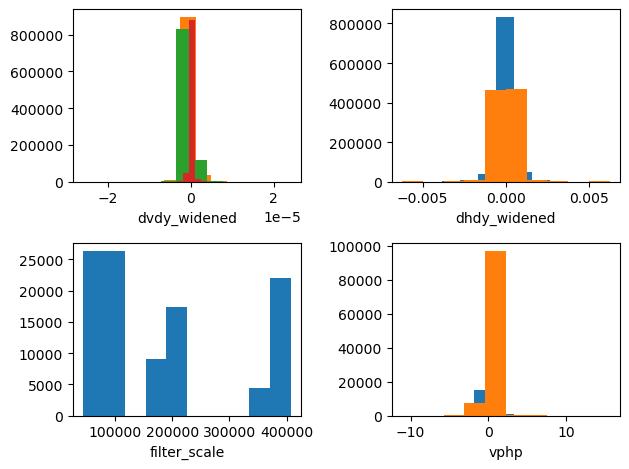

In [10]:
plt.subplot(221)
batch_xr[experiment_config['input_channels'][0]].plot.hist();
batch_xr[experiment_config['input_channels'][1]].plot.hist();
batch_xr[experiment_config['input_channels'][2]].plot.hist();
batch_xr[experiment_config['input_channels'][3]].plot.hist();

plt.subplot(222)
batch_xr[experiment_config['input_channels'][4]].plot.hist();
batch_xr[experiment_config['input_channels'][5]].plot.hist();

plt.subplot(223)
batch_xr[experiment_config['input_channels'][6]].plot.hist();

plt.subplot(224)
batch_xr[experiment_config['output_channels'][0]].plot.hist();
batch_xr[experiment_config['output_channels'][1]].plot.hist();

plt.tight_layout()

In [11]:
batch_xr.std()

<xarray.Dataset> Size: 64B
Dimensions:       ()
Data variables:
    dudx_widened  float64 8B 4.217e-07
    dvdx_widened  float64 8B 9.087e-07
    dudy_widened  float64 8B 6.326e-07
    dvdy_widened  float64 8B 4.233e-07
    dhdx_widened  float64 8B 0.0005538
    dhdy_widened  float64 8B 0.0005355
    filter_scale  float64 8B 1.298e+05
    uphp          float32 4B 0.4085
    vphp          float32 4B 0.6

In [12]:
normalize_data_dic = {
    'dudx_widened': ([], 1e-7),  # scalar value
    'dvdx_widened': ([], 1e-7),
    'dudy_widened': ([], 1e-7),
    'dvdy_widened': ([], 1e-7),
    'dhdx_widened': ([], 1e-4),
    'dhdy_widened': ([], 1e-4),
    'dhbardx_widened': ([], 1e-3),
    'dhbardy_widened': ([], 1e-3),
    'filter_scale': ([], 140e3),
    'Rd': ([], 5e3),
    'uphp': ([], .4),
    'vphp': ([], .4)}

ds_norm = xr.Dataset(normalize_data_dic)

In [13]:
wandb.config.update({"normalization_constants": normalize_data_dic})

In [14]:
# Define the variables and assign normalizations 

# normalize_data_dic = {
#     'dudx': ([], 1e-6),  # scalar value
#     'dvdx': ([], 1e-6),
#     'dudy': ([], 1e-6),
#     'dvdy': ([], 1e-6),
#     'dhdx': ([], 1e-3),
#     'dhdy': ([], 1e-3),
#     'dedx_middle': ([], 1e-3),
#     'dedy_middle': ([], 1e-3),
#     'filter_scale': ([], 140e3),
#     'uphp': ([], 4.),
#     'vphp': ([], 4.),

#     'dudx_nondim': ([], 1.),  # scalar value
#     'dvdx_nondim': ([], 1.),
#     'dudy_nondim': ([], 1.),
#     'dvdy_nondim': ([], 1.),
    
#     'uphp_nondim': ([], 1e-5),
#     'vphp_nondim': ([], 1e-5),

#     'dudx_widened': ([], 1e-6),  # scalar value
#     'dvdx_widened': ([], 1e-6),
#     'dudy_widened': ([], 1e-6),
#     'dvdy_widened': ([], 1e-6),
#     'dhdx_widened': ([], 1e-3),
#     'dhdy_widened': ([], 1e-3),
#     'dedx_middle_widened': ([], 1e-3),
#     'dedy_middle_widened': ([], 1e-3),
#     'dhdx_widened_rotated': ([], 1e-3),
#     'dhdy_widened_rotated': ([], 1e-3),
    
#     'dudx_widened_rotated_nondim': ([], 1e-1),  # scalar value
#     'dvdx_widened_rotated_nondim': ([], 1e-1),
#     'dudy_widened_rotated_nondim': ([], 1e-1),
#     'dvdy_widened_rotated_nondim': ([], 1e-1),
#     'dhdx_widened_rotated_nondim': ([], 1e-1),
#     'dhdy_widened_rotated_nondim': ([], 1e-1),
#     'uphp_rotated_nondim': ([], 1e-5),
#     'vphp_rotated_nondim': ([], 1e-5),
# }

# ds_norm = xr.Dataset(normalize_data_dic)

In [15]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      ds_norm=ds_norm)

test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      ds_norm=ds_norm)

ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

In [16]:
for batch_out in ML_data_combo['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (105433, 55)
Output (y) batch shape: (105433, 2)


In [17]:
num_in = batch_out['X'].shape[-1]
experiment_config['num_inputs'] = num_in

In [18]:
wandb.config.update({"num_in": experiment_config['num_inputs']})

In [19]:
experiment_config['num_inputs']

55

In [20]:
ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                    shape = experiment_config['network_shape']) 

In [21]:
ANN_model.count_parameters()

1994


In [22]:
regress_sys = ML_classes.AnnRegressionSystem(ANN_model)

In [23]:
%%time 
regress_sys.train_system(ML_data_combo, num_epoch=101, print_freq=2, use_wandb=True)

At epoch 1. Train loss :  2.6373169325493477 , Test loss: 1.2797367334365846
At epoch 3. Train loss :  1.0534463863115053 , Test loss: 1.06019868850708
At epoch 5. Train loss :  0.9113959766723014 , Test loss: 0.9259804010391235
At epoch 7. Train loss :  0.8169954725213953 , Test loss: 0.8451662182807922
At epoch 9. Train loss :  0.7678705067247957 , Test loss: 0.7974966168403625
At epoch 11. Train loss :  0.7277346849441528 , Test loss: 0.7627768874168396
At epoch 13. Train loss :  0.6968908938201698 , Test loss: 0.7274089932441712
At epoch 15. Train loss :  0.6666761878374461 , Test loss: 0.7012404680252076
At epoch 17. Train loss :  0.6440456316277787 , Test loss: 0.678706419467926
At epoch 19. Train loss :  0.6234586399954718 , Test loss: 0.6619562149047852
At epoch 21. Train loss :  0.6000611588761613 , Test loss: 0.6285005331039428
At epoch 23. Train loss :  0.5742811093459258 , Test loss: 0.6097631573677063
At epoch 25. Train loss :  0.5921334978696462 , Test loss: 0.61027001142

Clearly and obviously this loss is a function of the normalization that is used. 

In [24]:
regress_sys.save_checkpoint(experiment_config['exp_ckpt_save_dir'])

wandb: 🚀 View run deft-river-17 at: https://wandb.ai/m2lines/dimensional_models/runs/m6mk0oo1
wandb: Find logs at: wandb/run-20241025_185140-m6mk0oo1/logs


### Model evaluation 

In [27]:
test_eval = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 extra_channels=experiment_config['extra_channels'], 
                                 ds_norm_factors=ds_norm,
                                 eval_time_slice=slice(1000, 1010), 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=experiment_config['network_shape'], 
                                 ckpt_dir=experiment_config['exp_ckpt_save_dir'])

In [28]:
# Spin up eval pack
test_eval.read_ann_regression_model()
test_eval.read_eval_data()
test_eval.predict()

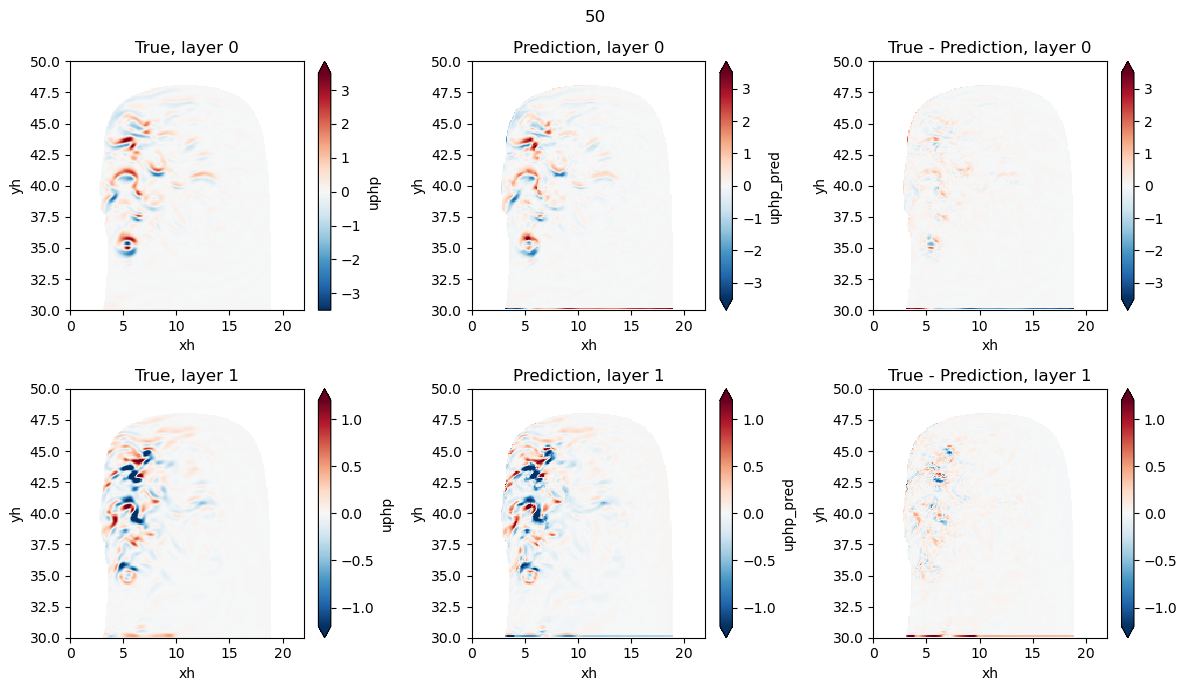

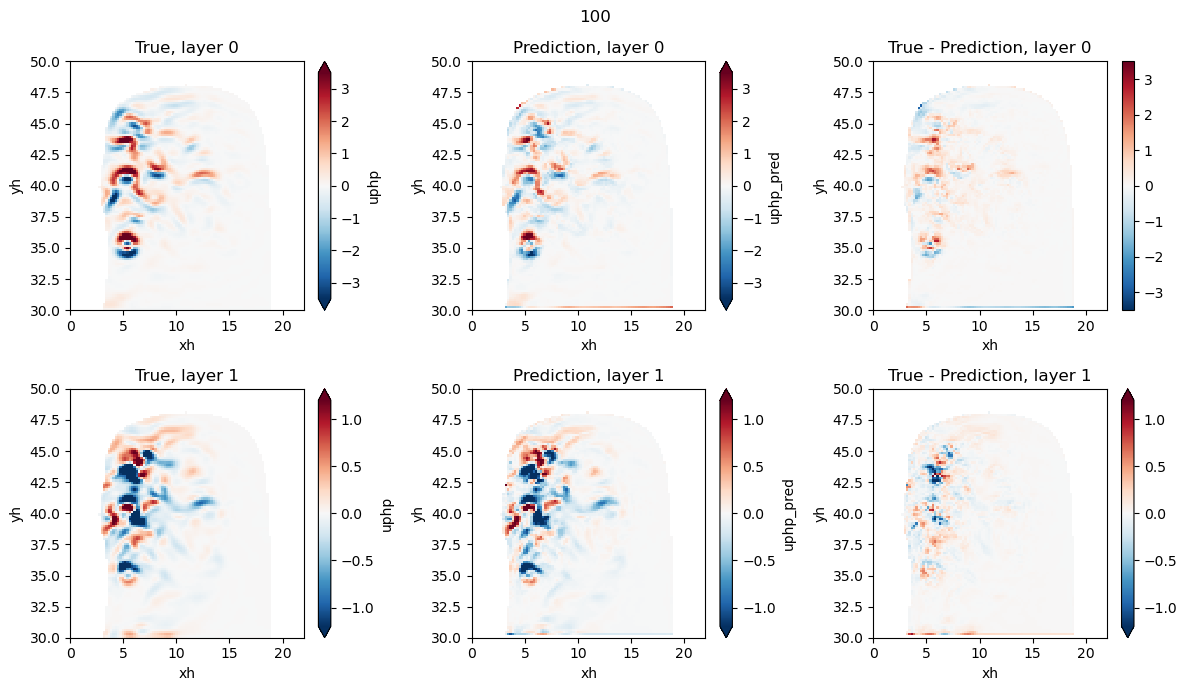

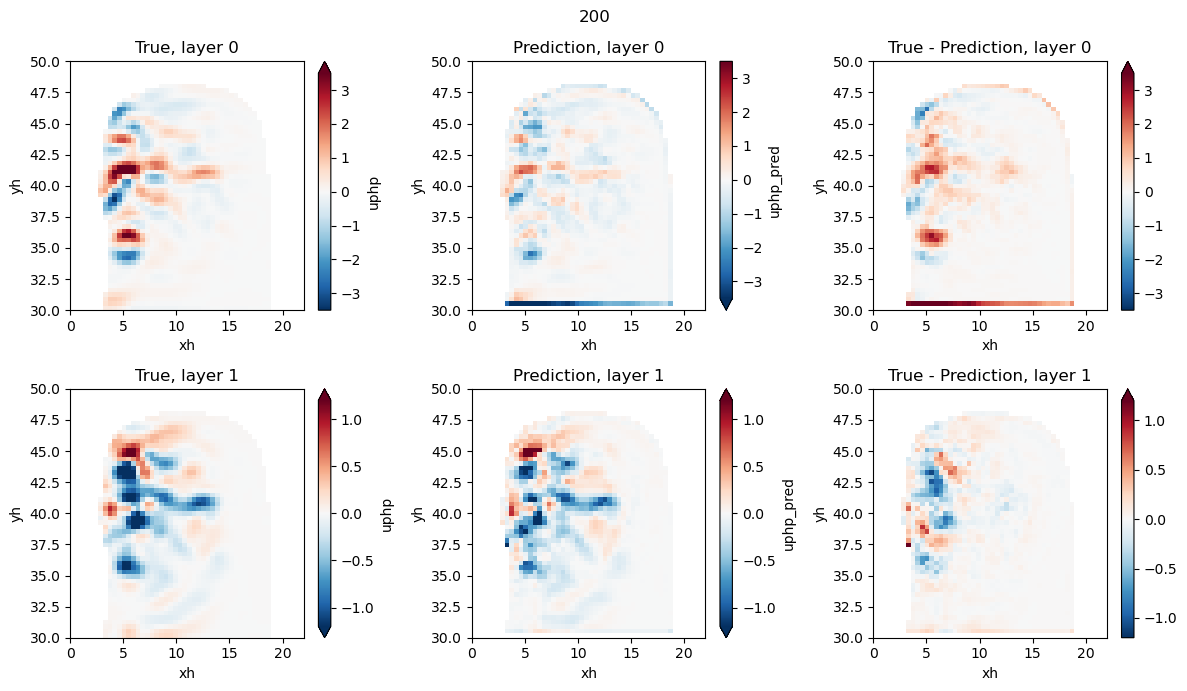

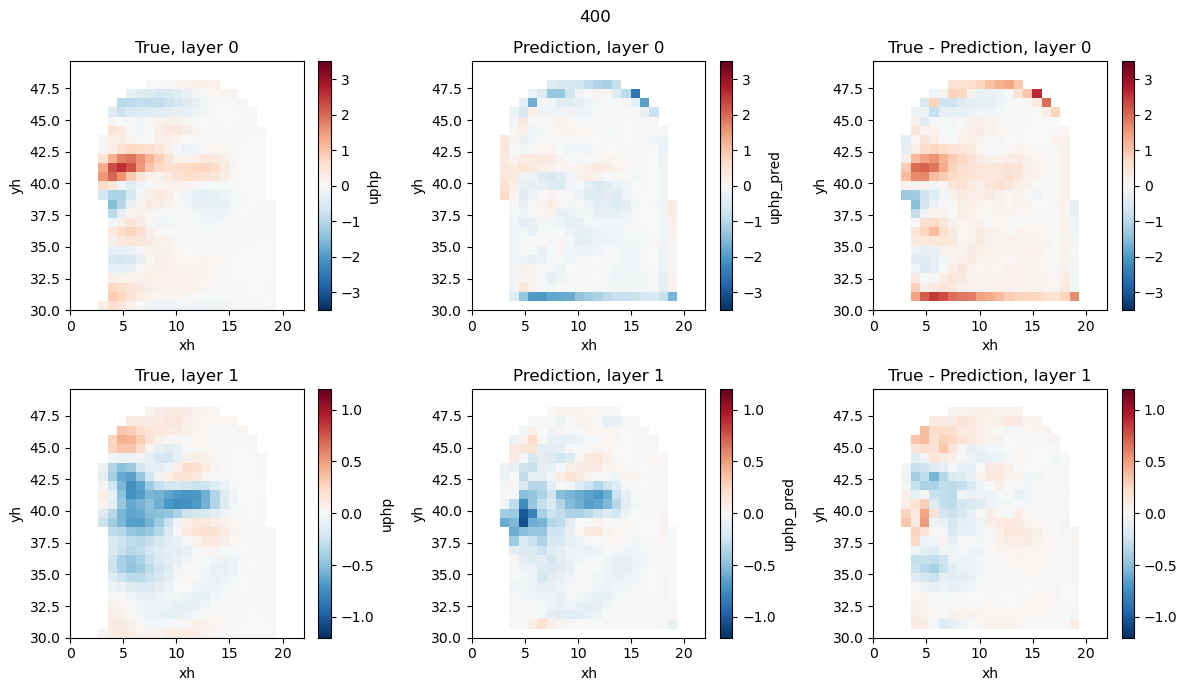

In [29]:
exp = experiment_config['simulation_names'][0]
var = experiment_config['output_channels'][0]

for scale in experiment_config['filter_scales']:

    plt.figure(figsize=(12, 7))
    
    vmin=-3.5
    zl_choice = 0
    
    plt.subplot(231)
    test_eval.eval_datatree.ml_dataset[exp][scale][var].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True, layer 0')
    
    plt.subplot(232)
    test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('Prediction, layer 0')
    
    plt.subplot(233)
    (test_eval.eval_datatree.ml_dataset[exp][scale][var] - 
     test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True - Prediction, layer 0')
    
    vmin=-1.2 
    zl_choice = 1
    
    plt.subplot(234)
    test_eval.eval_datatree.ml_dataset[exp][scale][var].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True, layer 1')
    
    plt.subplot(235)
    test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('Prediction, layer 1')
    
    plt.subplot(236)
    (test_eval.eval_datatree.ml_dataset[exp][scale][var] - 
     test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True - Prediction, layer 1')
    
    plt.suptitle(scale)
    plt.tight_layout()
    
    #wandb.Image(plt)
    #wandb.log({'chart':plt})
    
    # buf = io.BytesIO()
    # fig.savefig(buf, format='png')
    # buf.seek(0)
    
    # Log the figure to W&B
    plt_key = var+ '_panels_' + scale
    wandb.log({plt_key: wandb.Image(plt)})

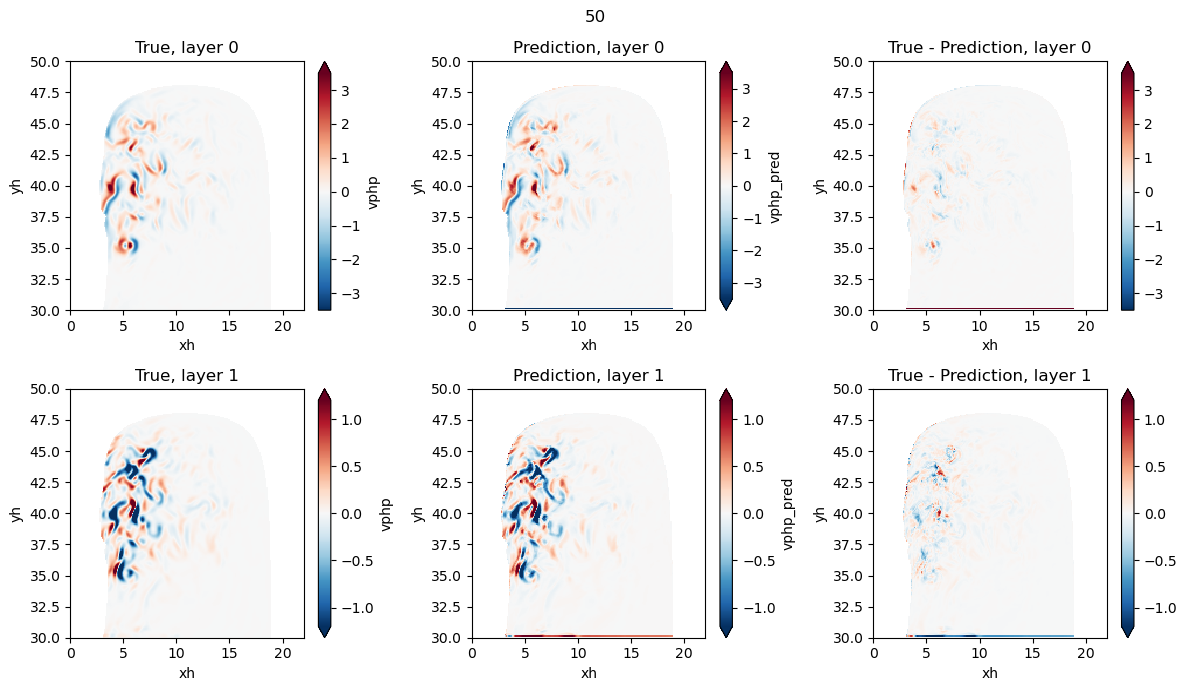

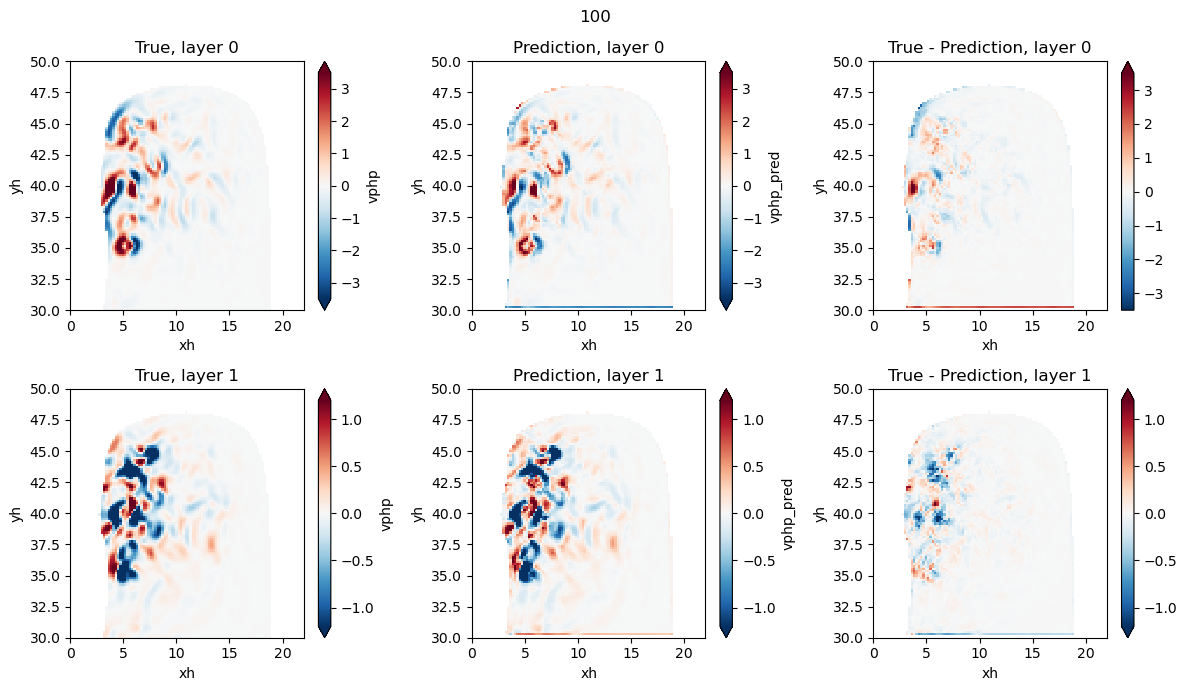

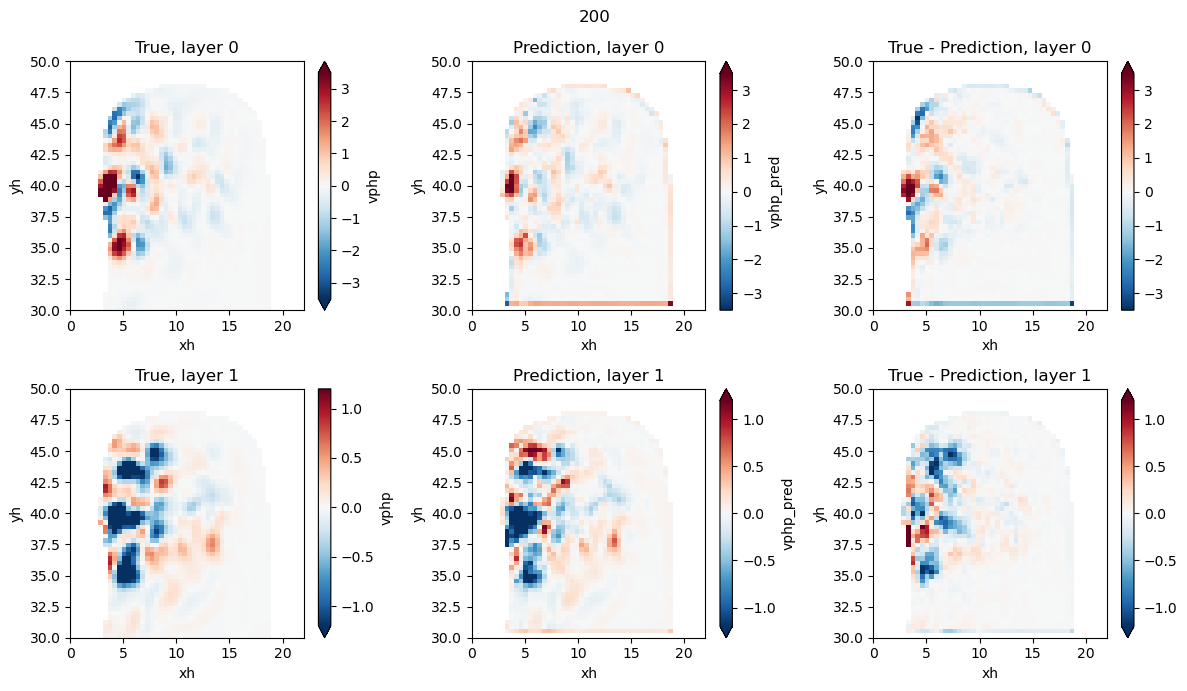

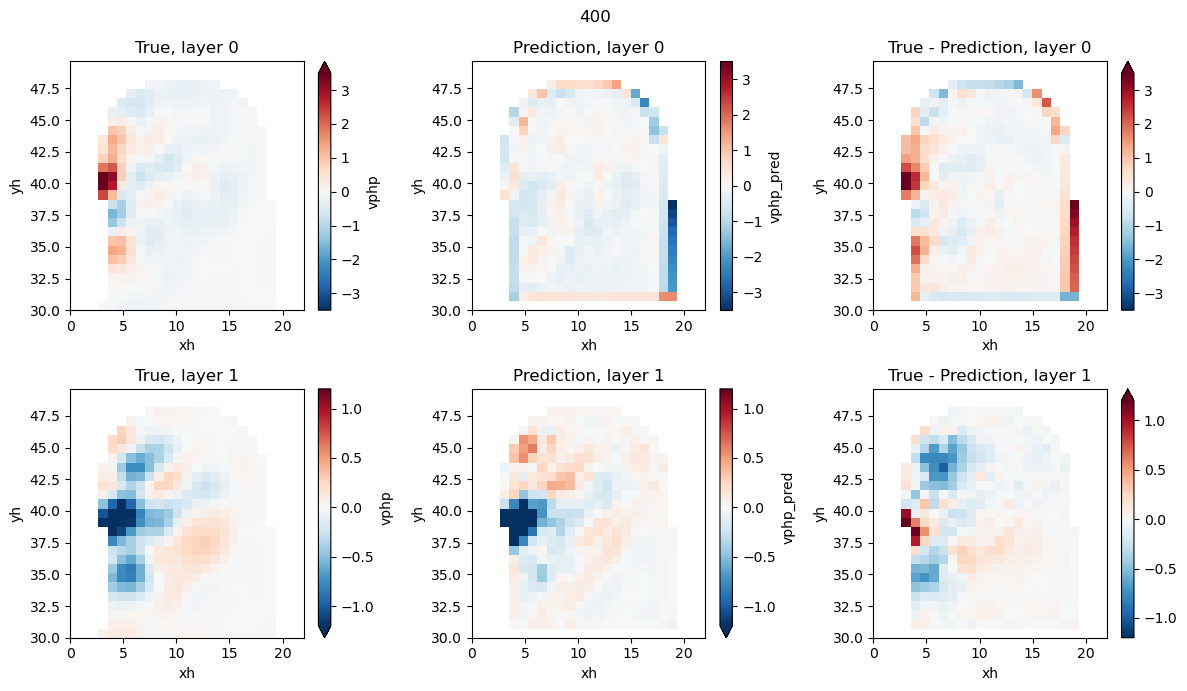

In [30]:
exp = experiment_config['simulation_names'][0]
var = experiment_config['output_channels'][1]

for scale in experiment_config['filter_scales']:

    plt.figure(figsize=(12, 7))
    
    vmin=-3.5
    zl_choice = 0
    
    plt.subplot(231)
    test_eval.eval_datatree.ml_dataset[exp][scale][var].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True, layer 0')
    
    plt.subplot(232)
    test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('Prediction, layer 0')
    
    plt.subplot(233)
    (test_eval.eval_datatree.ml_dataset[exp][scale][var] - 
     test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True - Prediction, layer 0')
    
    vmin=-1.2 
    zl_choice = 1
    
    plt.subplot(234)
    test_eval.eval_datatree.ml_dataset[exp][scale][var].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True, layer 1')
    
    plt.subplot(235)
    test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('Prediction, layer 1')
    
    plt.subplot(236)
    (test_eval.eval_datatree.ml_dataset[exp][scale][var] - 
     test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True - Prediction, layer 1')
    
    plt.suptitle(scale)
    plt.tight_layout()
    
    #wandb.Image(plt)
    #wandb.log({'chart':plt})
    
    # buf = io.BytesIO()
    # fig.savefig(buf, format='png')
    # buf.seek(0)
    
    # Log the figure to W&B
    plt_key = var+ '_panels_' + scale
    wandb.log({plt_key: wandb.Image(plt)})

In [31]:
# Pick some region away from boundaries to do that stats 

In [32]:
#test_eval.calc_time_hor_space_metrics(yh_region=slice(31, 45), xh_region=slice(5, 17), dims=['Time','xh','yh'])
#test_eval.calc_time_hor_space_metrics(var='vphp',yh_region=slice(31, 45), xh_region=slice(5, 17), dims=['Time','xh','yh'])

In [33]:
test_eval.calc_time_hor_space_metrics(var='uphp', yh_region=slice(31, 50),  descriptor='all_space_time', dims=['Time','xh','yh','zl'])
test_eval.calc_time_hor_space_metrics(var='vphp', yh_region=slice(31, 50),descriptor='all_space_time', dims=['Time','xh','yh','zl'])

test_eval.calc_time_hor_space_metrics(var='uphp', yh_region=slice(31, 50),descriptor='layer_wise', dims=['Time','xh','yh'])
test_eval.calc_time_hor_space_metrics(var='vphp', yh_region=slice(31, 50), descriptor='layer_wise', dims=['Time','xh','yh'])

In [39]:
test_eval.calc_time_hor_space_metrics(var='uphp', descriptor='time', dims=['Time'])
test_eval.calc_time_hor_space_metrics(var='vphp', descriptor='time', dims=['Time'])


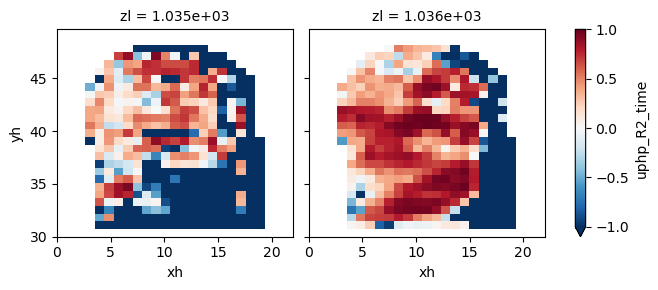

In [45]:
test_eval.eval_datatree.ml_dataset[exp]['400'].uphp_R2_time.plot(col='zl', vmax=1)

In [34]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_R2_layer_wise.values))
        print(exp+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_R2_layer_wise.values))

DG 50km, R2 for uphp is (layer:[0,1])[0.85063791 0.86989252]
DG 50km, R2 for vphp is (layer:[0,1])[0.88225441 0.88451555]
DG 100km, R2 for uphp is (layer:[0,1])[0.79247715 0.88786042]
DG 100km, R2 for vphp is (layer:[0,1])[0.79992695 0.90565086]
DG 200km, R2 for uphp is (layer:[0,1])[0.57973045 0.78000712]
DG 200km, R2 for vphp is (layer:[0,1])[0.54791525 0.8360636 ]
DG 400km, R2 for uphp is (layer:[0,1])[-0.45265003  0.68646816]
DG 400km, R2 for vphp is (layer:[0,1])[-0.63196782  0.64563192]


In [35]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+', corr for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_corr_layer_wise.values))
        print(exp+' '+scale+', corr for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_corr_layer_wise.values))

DG 50, corr for uphp is (layer:[0,1])[0.9242812  0.93829171]
DG 50, corr for vphp is (layer:[0,1])[0.93942642 0.94439718]
DG 100, corr for uphp is (layer:[0,1])[0.908999   0.94162268]
DG 100, corr for vphp is (layer:[0,1])[0.91200797 0.95209319]
DG 200, corr for uphp is (layer:[0,1])[0.79091162 0.87877338]
DG 200, corr for vphp is (layer:[0,1])[0.76259906 0.91359887]
DG 400, corr for uphp is (layer:[0,1])[0.31709303 0.80417422]
DG 400, corr for vphp is (layer:[0,1])[0.11225518 0.80276281]


In [36]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+', MSE for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_mse_layer_wise.values))
        print(exp+' '+scale+', MSE for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_mse_layer_wise.values))

DG 50, MSE for uphp is (layer:[0,1])[0.01403757 0.00444717]
DG 50, MSE for vphp is (layer:[0,1])[0.02170598 0.00655394]
DG 100, MSE for uphp is (layer:[0,1])[0.0669126  0.00969892]
DG 100, MSE for vphp is (layer:[0,1])[0.14400608 0.01555185]
DG 200, MSE for uphp is (layer:[0,1])[0.15660713 0.02141322]
DG 200, MSE for vphp is (layer:[0,1])[0.3758719  0.03385478]
DG 400, MSE for uphp is (layer:[0,1])[0.27146954 0.01662383]
DG 400, MSE for vphp is (layer:[0,1])[0.62419757 0.04221089]


In [37]:
## Write scalewise summary metrics into wandb 

R2_list = np.array([])
corr_list = np.array([])
mse_list = np.array([])

for scale in experiment_config['filter_scales']:

    mse = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_mse_all_space_time.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_mse_all_space_time.values)
    corr = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_corr_all_space_time.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_corr_all_space_time.values)
    R2 = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_R2_all_space_time.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_R2_all_space_time.values)
    
    wandb.run.summary['mse_'+scale] = mse
    wandb.run.summary['R2_'+scale] = R2
    wandb.run.summary['corr_'+scale] = corr
    R2_list = np.append(R2_list, R2)
    corr_list = np.append(corr_list, corr)
    mse_list = np.append(mse_list, mse)

wandb.run.summary['mse'] = np.mean(mse_list)
wandb.run.summary['R2'] = np.mean(R2_list)
wandb.run.summary['corr'] = np.mean(corr_list)

for scale in experiment_config['filter_scales']:
    wandb.run.summary['mse_'+scale+'_layerwise'] = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_mse_layer_wise.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_mse_layer_wise.values)
    wandb.run.summary['R2_'+scale+'_layerwise'] = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_R2_layer_wise.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_R2_layer_wise.values)
    wandb.run.summary['corr_'+scale+'_layerwise'] = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_corr_layer_wise.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_corr_layer_wise.values)
    

In [38]:
wandb.finish()

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
test_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
R2,0.50848
R2_100,0.81614
R2_200,0.61323
R2_400,-0.26473
R2_50,0.86928
corr,0.74074
corr_100,0.91397
corr_200,0.79433


Note that the MSE values here are a bit larger than what we had in loss. This is for 2 reasons (i) There is a factor of 4 in normalization, and (ii) we divided the MSE in training by 2 out of convention. 